In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd

sys.path.append("../data/")
sys.path.append("../src/")
from classes import families, validate_family, add_tags
from subgraph_enumeration import generate_canonical_smarts

model_dir = '../results/mpnn03-repeat028'
figure_dir = 'Figures'

from openeye import oechem, oedepict, oegrapheme

from IPython.display import display_png, display, HTML
import oenotebook as oenb

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
font = {
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 18,
}
plt.rcParams.update(font)


In [2]:
output_dataset = pd.read_csv(model_dir + '/predictions.csv', index_col=0)
output_dataset.head()

,CNAME,smiles,neg RT (min),predicted neg RT (min),error neg RT (min),split,id_num,indole,phenyl,pyruvate,...,dicarboxylic acid,tricarboxylic acid,"sugar, amino sugar, sugar carboxylic acid",sugar monophosphate,sugar diphosphate,sugar diphosphate sugar,sugar diphosphate sugar phosphate,isomers,small but systematic changes,small and significant changes
0,SELENOMETHIONINE,C[Se]CCC(C(=O)O)N,6.25,7.775598,1.525598,test,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,L-LYSINE,C(CCCN)C(C(=O)O)N,22.99,23.589376,0.599376,train,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,L-ORNITHINE,C(CCN)C(C(=O)O)N,23.52,24.022165,0.502165,train,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DL-5-HYDROXYLYSINE,C(CCC(CN)O)(C(=O)O)N,23.54,24.269242,0.729242,train,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NORADRENALINE,C(CN)(c1cc(c(cc1)O)O)O,24.13,24.407094,0.277094,train,4,0,1,0,...,0,0,0,0,0,0,0,14,0,0


In [3]:
contrib_tagname = "Contributions"
contrib_tag = oechem.OEGetTag(contrib_tagname)
expt_tagname = "Expt"
expt_tag = oechem.OEGetTag(expt_tagname)
pred_tagname = "Pred"
pred_tag = oechem.OEGetTag(pred_tagname)
error_tagname = "Error"
error_tag = oechem.OEGetTag(error_tagname)

ifs = oechem.oemolistream(model_dir + '/elucidation/contributions.sdf')
ofs = oechem.oemolostream(model_dir + '/elucidation/contributions.oeb')
#smi_ofs = oechem.oemolostream(model_dir + '/elucidation/smiles.smi')

for mol_no, mol in enumerate(ifs.GetOEGraphMols()):
    coords = mol.GetCoords()
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        assert atom_idx == int(coords[atom_idx][0])
        assert atom.GetAtomicNum() == int(coords[atom_idx][1])
        atom.SetData(contrib_tag, coords[atom_idx][2])
    
    mol.SetTitle(output_dataset.loc[mol_no, 'smiles'])
    mol.SetData(expt_tag, output_dataset.loc[mol_no, 'neg RT (min)'])
    mol.SetData(pred_tag, output_dataset.loc[mol_no, 'predicted neg RT (min)'])
    mol.SetData(error_tag, output_dataset.loc[mol_no, 'error neg RT (min)'])
    
    mol2 = mol.CreateCopy()
    #oechem.OEWriteMolecule(smi_ofs, mol2)
    oechem.OEWriteMolecule(ofs, mol)
print(f"Done writing {mol_no+1} molecules.")

Done writing 398 molecules.


# Identify Key Features

Let us test whether we can extract and plot the individual atom contributions

## Count molecules in database

In [4]:
ifs = oechem.oemolistream(model_dir + '/elucidation/contributions.oeb')
good_predictions = 0
for mol_no, mol in enumerate(ifs.GetOEGraphMols()):
    if mol.GetData(error_tag) < 2.0:
        good_predictions += 1

print(f"Total molecules: {mol_no + 1}")
print(f"Good predictions: {good_predictions}")

Total molecules: 354
Good predictions: 333


## Plot Contributions

In [5]:
def plot_contributions(disp, opts, minvalue=None, maxvalue=None):
    
    propmap = oegrapheme.OE2DPropMap(opts.GetBackgroundColor())
    propmap.SetPositiveColor(oechem.OEDarkRed)
    propmap.SetNegativeColor(oechem.OEDarkBlue)
    if minvalue and maxvalue:
        propmap.SetMinValue(minvalue)
        propmap.SetMaxValue(maxvalue)
    propmap.Render(disp, contrib_tagname)
    
    return disp


def get_molecule(mol_idx):
    ifs = oechem.oemolistream(model_dir + '/elucidation/contributions.oeb')

    mol = oechem.OEGraphMol()
    mol_counter = 0
    while mol_counter <= mol_idx:
        if not oechem.OEReadMolecule(ifs, mol):
            oechem.OEThrow.Fatal(f"The file only contains {mol_counter} molecules.")
            break
        mol_counter += 1
    
    return mol

def setup_disp(mol, width, height, scale, bgcolor):
    opts = oedepict.OE2DMolDisplayOptions(width, height, scale)
    opts.SetAtomColorStyle(oedepict.OEAtomColorStyle_WhiteMonochrome)
    opts.SetTitleLocation(oedepict.OETitleLocation_Hidden)
    opts.SetScale(oegrapheme.OEGetMoleculeSurfaceScale(mol, opts))
    disp = oedepict.OE2DMolDisplay(mol, opts)

    return disp, opts

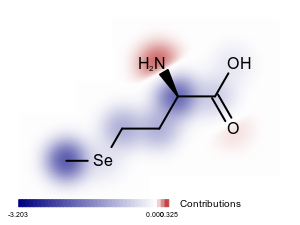

In [6]:
mol_idx = 0
mol = get_molecule(0)
oedepict.OEPrepareDepiction(mol)    

dpi=300
width, height, scale, bgcolor = 1.0*dpi, 0.75*dpi, oedepict.OEScale_AutoScale, oechem.OETransparentColor
disp, opts = setup_disp(mol, width, height, scale, bgcolor)
disp = plot_contributions(disp, opts)

image = oedepict.OEImage(width, height, bgcolor)
oedepict.OERenderMolecule(image, disp)
img_str = oedepict.OEWriteImageToString("png", image)
display_png(img_str, raw=True)

## Test Subgraph Enumeration

In [7]:
def draw_subsearch_highlights(mol2, subsearch, width=400., height=400.):
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    mol = mol2.CreateCopy()
    mol = oechem.OEGraphMol(mol)
    oedepict.OEPrepareDepiction(mol)
    img = oedepict.OEImage(width, height)
    hstyle = oedepict.OEHighlightByBallAndStick(oechem.OEBlueTint)

    disp = oedepict.OE2DMolDisplay(mol, opts)
    unique = True
    for match in subsearch.Match(mol, unique):
        oedepict.OEAddHighlighting(disp, hstyle, match)
    
    oedepict.OERenderMolecule(img, disp)
    return img

## Generate Database of Subgraphs

In [8]:
start_time = time.time()
contrib_data = []
ifs = oechem.oemolistream(model_dir + '/elucidation/contributions.oeb')
print("Starting ...")
good_predictions = 0
for mol_no, mol in enumerate(ifs.GetOEGraphMols()):
    if mol.GetData(error_tag) < 2.0:
        good_predictions += 1
    else:
        continue
    sys.stdout.write(f"\rProcessing Molecule {mol_no+1:3d}")
    sys.stdout.flush()
    
    predicted_elution_time = mol.GetData(pred_tag)
    prediction_error = mol.GetData(error_tag)
    assert prediction_error < 2.0
    for subgraph_no, subgraph in enumerate(set(generate_canonical_smarts(mol, 5))):   
        #print(subgraph)
        ss = oechem.OESubSearch(subgraph)

#         img = draw_subsearch_highlights(mol, ss)
#         img_str = oedepict.OEWriteImageToString("png", img)
#         display_png(img_str, raw=True)

        for match in ss.Match(mol, True):
            total_contrib = 0.0
            for ma in match.GetAtoms():
                total_contrib += ma.target.GetData(contrib_tag)
            abs_total_contrib = abs(total_contrib)
            rel_contrib = total_contrib / predicted_elution_time
            abs_rel_contrib = abs(rel_contrib)
            contrib_data.append([
                mol_no,
                mol.GetTitle(),
                predicted_elution_time,
                prediction_error,
                subgraph,
                total_contrib,
                abs_total_contrib,
                rel_contrib,
                abs_rel_contrib
            ])
            #print(f"{total_contrib:.2f} {rel_contrib:.2f}")
            #print("\n")
print("\n")
print(f"Done evaluating subgraphs in {good_predictions} molecules in {time.time() - start_time:.2f}s.")        

Starting ...
Processing Molecule 354Warning: Error reading from OEBinary v2, return value was "Incorrect Size"


Done evaluating subgraphs in 333 molecules in 16.06s.


## Analyze Subgraphs

In [9]:
contrib_dataset = pd.DataFrame.from_records(contrib_data, 
                                           columns=[
                                               'ID',
                                               'smiles',
                                               'predicted neg RT (min)',
                                               'error neg RT (min)',
                                               'subgraph',
                                               'total_contrib',
                                               'abs_total_contrib',
                                               'rel_contrib',
                                               'abs_rel_contrib',
                                           ])
contrib_dataset.head()

,ID,smiles,predicted neg RT (min),error neg RT (min),subgraph,total_contrib,abs_total_contrib,rel_contrib,abs_rel_contrib
0,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CC(CO)N,-5.4940,5.4940,-0.706569,0.706569
1,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CCC[Se],-6.5170,6.5170,-0.838135,0.838135
2,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,O,0.0648,0.0648,0.008334,0.008334
3,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,O,-0.4261,0.4261,-0.054800,0.054800
4,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CCO,-4.3432,4.3432,-0.558568,0.558568


In [10]:
print(len(contrib_dataset))
print(contrib_dataset['subgraph'].nunique())

40349
803


In [11]:
contrib_dataset.to_csv(model_dir+'/elucidation/subgraph_contributions.csv')

### Filter

In [12]:
def good_subgraph(s):
    return not(
        len(set(s) - set("cnC()")) == 0 or
        len(set(s) - set("cnO()=")) == 0 or
        len(set(s) - set("cnN()=")) == 0 or
        s.islower()
    )

In [13]:
contrib_dataset['good_subgraph'] = np.vectorize(good_subgraph)(contrib_dataset['subgraph'])

In [14]:
contrib_dataset = contrib_dataset[contrib_dataset['good_subgraph'] == True]
contrib_dataset['subgraph'].nunique()

613

### Counts

In [15]:
contrib_dataset['frequency'] = contrib_dataset.groupby('subgraph')['subgraph'].transform('count')
contrib_dataset.head()

,ID,smiles,predicted neg RT (min),error neg RT (min),subgraph,total_contrib,abs_total_contrib,rel_contrib,abs_rel_contrib,good_subgraph,frequency
0,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CC(CO)N,-5.4940,5.4940,-0.706569,0.706569,True,88
1,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CCC[Se],-6.5170,6.5170,-0.838135,0.838135,True,1
4,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CCO,-4.3432,4.3432,-0.558568,0.558568,True,1406
7,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CCCN,-5.6724,5.6724,-0.729513,0.729513,True,101
8,0,C[Se]CCC(C(=O)O)N,7.775598,1.525598,CCC=O,-5.3281,5.3281,-0.685233,0.685233,True,250


Text(0,0.5,'Subgraph Frequency')

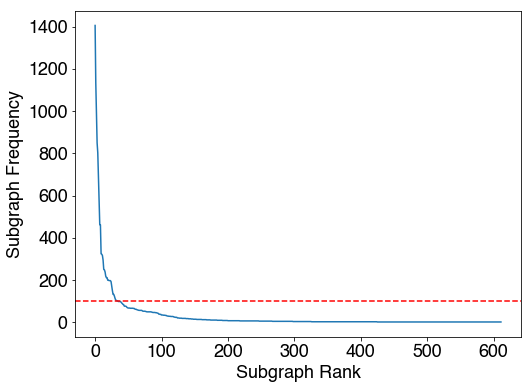

In [16]:
f = contrib_dataset['subgraph'].value_counts().values
f.sort()
f = f[-1:0:-1]

font = {
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',
    'font.size': 18,
}
plt.rcParams.update(font)
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(np.arange(len(f)), f)
ax1.axhline(y=100, color='r', linestyle='--')
ax1.set_xlabel("Subgraph Rank")
ax1.set_ylabel("Subgraph Frequency")

In [17]:
# Amide
contrib_dataset[contrib_dataset['subgraph'] == 'CC(=O)NC']['frequency'].values[0]

32

In [18]:
threshold = 30
contrib_dataset = contrib_dataset[contrib_dataset['frequency'] > threshold]
contrib_dataset['subgraph'].nunique()

108

In [19]:
func_groups = ['CO',
               'C=O',
               'C=C',
               'CN',
               'C(=O)O',
              ]

In [20]:
subgraph_summary = contrib_dataset.groupby('subgraph')[['total_contrib', 
                                     'abs_total_contrib', 
                                     'rel_contrib', 
                                     'abs_rel_contrib',
                                     'frequency']].mean().sort_values('rel_contrib')
subgraph_summary

,total_contrib,abs_total_contrib,rel_contrib,abs_rel_contrib,frequency
subgraph,,,,,
C=CCCC,-7.423336,9.518088,-2.832254,2.980397,33
CC=CCC,-5.964765,8.097269,-2.368875,2.519688,48
CC(C)CO,-9.956362,11.314357,-2.284673,2.342398,37
cccC=O,-7.011233,12.724444,-1.946987,2.309803,52
CCNCC,-9.389020,10.831531,-1.877610,1.947981,61
cccCO,-4.081909,14.454539,-1.750900,2.342944,46
C=CCC,-4.888778,5.997471,-1.726703,1.805325,45
C1CCOC1,-11.146163,12.073715,-1.681575,1.705857,54
C(Cn)CO,-9.875056,11.120980,-1.619058,1.650259,50


In [21]:
contrib_dataset.groupby('subgraph')[['total_contrib', 
                                     'abs_total_contrib', 
                                     'rel_contrib', 
                                     'abs_rel_contrib', 
                                     'frequency']].mean().sort_values('rel_contrib').to_csv(
    figure_dir+'/../subgraph_contributions.csv')

## Figures

In [22]:
def plot_functional_group_contribution(functional_group, minvalue=None, maxvalue=None, mol_idx0=None, mol_idx1=None, zoom=1.0, criterion='relative'):
    if criterion == 'relative':
        rel_contrib = subgraph_summary.loc[functional_group]['rel_contrib']
        print(f"Mean Relative Contribution: {rel_contrib:.2f}")
        sorted_df = contrib_dataset[contrib_dataset['subgraph'] == functional_group].sort_values('rel_contrib', ascending=(rel_contrib < 0))
    
    if criterion == 'absolute':
        total_contrib = subgraph_summary.loc[functional_group]['total_contrib']
        print(f"Mean Total Contribution: {total_contrib:.2f}")
        sorted_df = contrib_dataset[contrib_dataset['subgraph'] == functional_group].sort_values('total_contrib', ascending=(total_contrib < 0))
    
    if mol_idx0 is None or mol_idx1 is None:
        selected_mol_indices = sorted_df['ID'].values[:2]
        mol_idx0, mol_idx1 = selected_mol_indices[0], selected_mol_indices[1]

    fg = oechem.OEGraphMol()
    oechem.OESmilesToMol(fg, functional_group)

    mol0, mol1 = get_molecule(mol_idx0), get_molecule(mol_idx1)
    for mol in (fg, mol0, mol1):
        oedepict.OEPrepareDepiction(mol)    

    dpi=300*2*1.025/4.2778*zoom
    width, height, scale, bgcolor = 1.025*dpi, 1.025*dpi, oedepict.OEScale_AutoScale, oechem.OETransparentColor
    opts_fg = oedepict.OE2DMolDisplayOptions(width, 0.525*dpi, scale)
    disp0, opts0 = setup_disp(mol0, width, height, scale, bgcolor)
    disp1, opts1 = setup_disp(mol1, width, height, scale, bgcolor)

    disp_fg = oedepict.OE2DMolDisplay(fg, opts_fg)
    disp0 = plot_contributions(disp0, opts0, minvalue, maxvalue)
    disp1 = plot_contributions(disp1, opts1, minvalue, maxvalue)

    image = oedepict.OEImage(1.125*dpi, 2.775*dpi, bgcolor)
    frame_fg = oedepict.OEImageFrame(image, width, 0.525*dpi, oedepict.OE2DPoint(0.05*dpi, 0.05*dpi))
    frame0 = oedepict.OEImageFrame(image, width, height, oedepict.OE2DPoint(0.05*dpi, 0.625*dpi))
    frame1 = oedepict.OEImageFrame(image, width, height, oedepict.OE2DPoint(0.05*dpi, 1.700*dpi))

    oedepict.OERenderMolecule(frame_fg, disp_fg)
    oedepict.OERenderMolecule(frame0, disp0)
    oedepict.OERenderMolecule(frame1, disp1)
    
    return image

In [23]:
minvalue = -7.0
maxvalue = 18

Mean Relative Contribution: 0.51


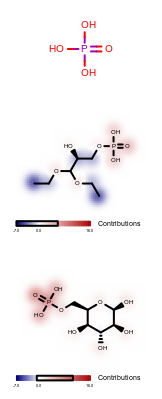

True

In [24]:
functional_group_name = 'Phosphate'
functional_group = 'O=P(O)(O)O'

image = plot_functional_group_contribution(functional_group, minvalue=-7, maxvalue=16)
img_str = oedepict.OEWriteImageToString("png", image)
display_png(img_str, raw=True)
oedepict.OEWriteImage(figure_dir + f"/{functional_group_name}_contribution.pdf", image)

Mean Relative Contribution: -0.04


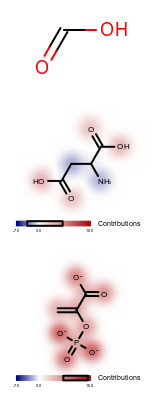

True

In [25]:
functional_group_name = 'Carboxylic_Acid'
functional_group = 'C(=O)O'
minvalue = -7.0
maxvalue = 11.0

image = plot_functional_group_contribution(functional_group, mol_idx0=326, mol_idx1=10, zoom=1.0, minvalue=-7, maxvalue=16)
img_str = oedepict.OEWriteImageToString("png", image)
display_png(img_str, raw=True)
oedepict.OEWriteImage(figure_dir + f"/{functional_group_name}_contribution.pdf", image)

Mean Relative Contribution: -1.09


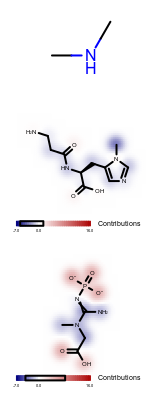

True

In [26]:
functional_group_name = 'Amine'
functional_group = 'CNC'

image = plot_functional_group_contribution(functional_group, mol_idx0=269, mol_idx1=112, zoom=1.0, minvalue=-7, maxvalue=16)
img_str = oedepict.OEWriteImageToString("png", image)
display_png(img_str, raw=True)
oedepict.OEWriteImage(figure_dir + f"/{functional_group_name}_contribution.pdf", image)

Mean Relative Contribution: -0.34


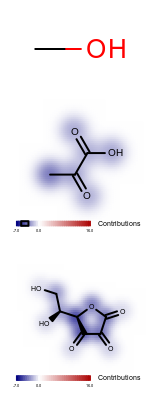

True

In [27]:
functional_group_name = 'Alcohol'
functional_group = 'CO'

image = plot_functional_group_contribution(functional_group, mol_idx0=110, mol_idx1=323, zoom=1.0, minvalue=-7, maxvalue=16)
img_str = oedepict.OEWriteImageToString("png", image)
display_png(img_str, raw=True)
oedepict.OEWriteImage(figure_dir + f"/{functional_group_name}_contribution.pdf", image)